[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/19QOjagB2QAKYgvbbGxf972iusMWjs9PD/view?usp=sharing)

# About this notebook

In this notebook, we apply CIDRE to the original example code in order to replicate the original experiments and aid in validating the results.

**The purpose of this notebook is to validate that the original CIDRE code (i) is functional (ii) can successfully detect desired behaviours (iii) has been replicated by a third party (myself, Gregory Pollard).**

This notebook uses lots of RAM and so can only be run with Google Colab Pro on a TPU runtime.

# CITATION:

The vanilla CIDRE algorithm was created by the authors below, the original CIDRE code resides on Github found [here](https://github.com/skojaku/cidre). The `detect_community()` mentioned in this notebook was also written by the authors.


**Paper:** Detecting anomalous citation groups in journal networks

**Authors:** Kojaku, Sadamori and Livan, Giacomo and Masuda, Naoki

**Journal:** Sci. Rep.

**Publisher:** Nature Publishing Group

# Preparation

CHANGE GOOGLE DRIVE TO GITHUB MAKE NEW ACCOUNT YOUR USED 1 GB FREE BANDWIDTH

## Install packages

First, we install `cidre` package with `pip`:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/CIDRE_Diss/Validation_Code/data/journal-citation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CIDRE_Diss/Validation_Code/data/journal-citation


In [3]:
!pip install cidre
!pip install github-contents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading libraries and pre-made methods

Next, we load some libraries:

In [4]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx
import math
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=20)

pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Finding communities requires the graph-tool package. This can be installed easily on Unix machines with:



```
conda install -c conda-forge graph-tool
```

Or, in Google Colab, we may use:

In [5]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
import graph_tool.all as gt

## Defining `detect_community()`

Before employing CIDRE, we need to detect the natural, healthy communities that form in journal networks and remove them. [In the original CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors defined `detect_community()` that utilises the [graph-tool](https://graph-tool.skewed.de/) package to do this. It should be noted that we will not use this function in this notebook as detecting communities in the aggregated network can take a very long time.

In [6]:
def detect_community(A, K = None, **params):
    """Detect communities using the graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities. If K = None, the number of communities is automatically determined by graph-tool.
    :type K: int or None
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": A.shape[0] if K is None else K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]


# Constructing the Aggregated Network

First, we generate the aggregated network used in the original study that was formed using the January 30th 2020 MAG data set snapshot. This network consists of all citations between all journals from 2000 to 2019 summed up. Here, we import the edge files for each yearly network. These networks were cleaned using `Datacleaner.py` applied to the aforementioned MAG snapshot. Each file is a collection of source-target MAG journal ID pairs with a weight for how many citations were passed from source to target, where the source is a paper from year T and the target is the journal of a cited paper from years T-1 or T-2 (JIF window).

In [7]:
# Find aggregated edge data

years = [y for y in range(2000,2020)]

# Load the node and edge files
df_edges = []
df_raw_edges = []

for year in years:
  temp_edges = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/edges-{}-1.csv".format(year), sep="\t")
  temp_edges1 = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/edges-{}-2.csv".format(year), sep="\t")
  temp_edges = temp_edges.append(temp_edges1)

  df_edges += [temp_edges]

df_edges = pd.concat(df_edges, ignore_index=True)

nodes = np.unique(df_edges[["source", "target"]].values.reshape(-1))
edges = df_edges[["source", "target", "w"]].values

# Compute the mapping from node ids to id
max_node_id = np.max(nodes)
node2id = -np.ones(max_node_id + 1)
node2id[nodes] = np.arange(nodes.size)

# Remove edges that do not exist in nodes list
edges = edges[(np.max(edges[:, :2], axis=1) <= max_node_id), :]

edges[:, :2] = node2id[edges[:, :2].reshape(-1)].reshape((edges.shape[0], 2))

# Remove edges that do not exist in nodes list again
edges = edges[(np.min(edges[:, :2], axis=1) >= 0), :]

# Adjacency matrix
N = len(nodes)
A = sparse.csr_matrix((edges[:, 2], (edges[:, 0], edges[:, 1])), shape=(N, N))

print(A)

  (0, 0)	292
  (0, 194)	1
  (0, 221)	1
  (0, 263)	21
  (0, 408)	1
  (0, 471)	1
  (0, 522)	1
  (0, 560)	2
  (0, 657)	1
  (0, 683)	26
  (0, 708)	1
  (0, 858)	1
  (0, 893)	1
  (0, 896)	1
  (0, 926)	1
  (0, 1056)	1
  (0, 1084)	1
  (0, 1408)	1
  (0, 1463)	1
  (0, 1558)	1
  (0, 1561)	1
  (0, 1670)	1
  (0, 1845)	8
  (0, 1966)	1
  (0, 2078)	4
  :	:
  (42355, 12122)	3
  (42355, 17299)	2
  (42355, 17883)	1
  (42355, 18113)	1
  (42355, 21657)	1
  (42355, 36752)	2
  (42356, 1035)	1
  (42356, 3848)	1
  (42356, 4334)	1
  (42356, 11977)	1
  (42356, 13089)	1
  (42356, 15948)	1
  (42356, 19048)	1
  (42356, 21943)	1
  (42356, 22070)	1
  (42356, 22287)	1
  (42356, 22549)	1
  (42356, 22643)	1
  (42356, 23080)	1
  (42356, 23555)	1
  (42356, 25111)	1
  (42356, 27062)	1
  (42356, 35677)	1
  (42356, 40237)	1
  (42356, 42356)	2


`A` is the adjacency matrix for the entire network of citations between journals from 1998 to 2020 according to the MAG data set (including citations from papers that were retracted from the MAG). We could detect the aggregated membership with `detect_community(A)`. However, this takes a very long time in Google Colab, so we will import the pre-made file here. Since we do this, we should delete all other data structures to save space.

`agg_comm = detect_community(A)`

Please run this segment instead:

In [8]:
del A,N,df_edges, df_raw_edges, edges, max_node_id, node2id, nodes, temp_edges, temp_edges1, year

agg_comm = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/agg_comm.csv",sep = "\t")

We're going to need to cycle over each yearly network, so let's make a function `load_net()` that can do this. Throughout this process, we need to construct the adjacency matrix for a given network, this must happen for the raw and non-raw edge tables, so we define a function `form_matrix()` to do this too.


In [9]:
def form_matrix(nodes, edges):

  # Compute mapping: node_id -> id
  max_node_id = np.max(nodes)
  node2id = -np.ones(max_node_id + 1)
  node2id[nodes] = np.arange(nodes.size)

  # Remove edges with IDs past years of interest
  edges = edges[(np.max(edges[:, :2], axis=1) <= max_node_id), :]

  edges[:, :2] = node2id[edges[:, :2].reshape(-1)].reshape((edges.shape[0], 2))

  # Remove edges with IDs before years of interest
  edges = edges[(np.min(edges[:, :2], axis=1) >= 0), :]

  # Adjacency matrix
  N = len(nodes)
  A = sparse.csr_matrix((edges[:, 2], (edges[:, 0], edges[:, 1])), shape=(N, N))

  return A

def load_net(year):

  # Load edge files
  df_edges = pd.read_csv("edges-{}-1.csv".format(year), sep="\t")

  for i in range(2,3):
    edge_filename = "edges-{}-{}.csv".format(year,i)
    temp = pd.read_csv(edge_filename, sep="\t")
    df_edges = df_edges.append(temp,ignore_index = True)
  
  df_edges = df_edges.reset_index(drop=True)

  nodes = np.unique(df_edges[["source", "target"]].values.reshape(-1))

  newnodes = []
  for id in agg_comm["journal_id"]:
    if id in nodes:
      newnodes.append(id)
  nodes = np.array(newnodes.copy())

  df_edges = df_edges[df_edges.source.isin(nodes)]

  edges = df_edges[["source", "target", "w"]].values

  # Construct matrices
  A = form_matrix(nodes, edges)

  return A, nodes

# Detecting anomalous groups in the network

Import each year's network and cycle over them, using the aggregated network as a null model to run CIDRE with. We use `theta = 0.15` to align with the JCR suppression policy, `alpha = 0.01` so that edges must be very significantly different to the aggregated network, `min_group_edge_num = 50` to replicate the parameters of the original study. Unfortunately, this process can also take a long time and so we shall import the detected cartels.

```python
yearly_cartels = dict()

for year in years:

  #Load adjacency matrix
  A_eff, nodes = load_net(year)

  # Find comm membership for this year
  year_comm_ids = (agg_comm.set_index("journal_id").loc[nodes, "community_id"].values)

  del A_gen
   
  # Employ CIDRE to detect cartels for this year
  cidreobj = cidre.Cidre(group_membership = year_comm_ids, alpha = 0.01, min_edge_weight = 10)
  groups = cidreobj.detect(A_eff, threshold = 0.15)

  # Omit groups smaller than 50 citations as in the original study
  groups = [group for group in groups if group.get_num_edges()>=50]

  # Save results
  yearly_cartels[year] = groups
  print("Cartels detected for: "+str(year))

  del groups,A_eff
  ```

Please run this segment instead:

In [11]:
yearly_cartels = dict()

for year in range(2000,2020):
  yearly_cartels[year] = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/cartels-{}.csv".format(year),sep = "\t")

# Validation of Results

With these cartels, let's recreate the barplot from the original paper detailing the number of groups detected by CIDRE yearly.

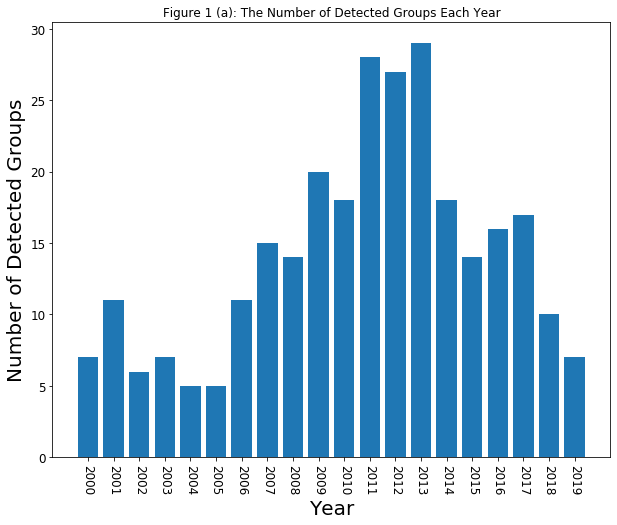

In [12]:
sizes = dict()
for year in range(2000,2020):
  sizes[str(year)] = yearly_cartels[year]["group_id"].nunique()

plt.rcParams["figure.figsize"] = [10, 8]
plt.bar(sizes.keys(),sizes.values())
plt.title('Figure 1 (a): The Number of Detected Groups Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Detected Groups')
plt.xticks(rotation=270)
plt.show()


Let's also recreate the boxplot detailing the size of detected groups for each group detected yearly. The Y-axis is scaled logarithmically.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


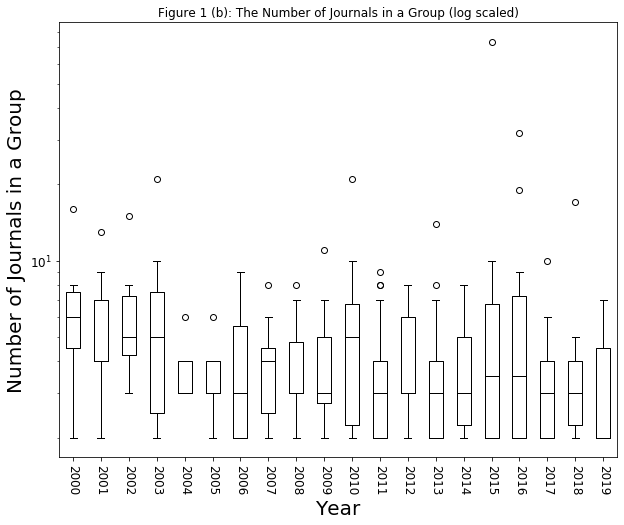

In [13]:
sizes = dict()
for year in range(2000,2020):
  sizes[year] = yearly_cartels[year]["group_id"].value_counts()

plt.rcParams["figure.figsize"] = [10, 8]
data = pd.DataFrame(sizes)
ax = data[data.columns].plot(kind='box',color = "k")

plt.yscale('log')
plt.xticks(rotation=270)
plt.title("Figure 1 (b): The Number of Journals in a Group (log scaled)")
plt.xlabel("Year")
plt.ylabel("Number of Journals in a Group")

# Display the plot
plt.show()

# Evaluation

A final step in validating the works of the original authors is to ensure that the groups presented in the plots above are identical to those found in the study.

First, we import the journal names of suppressed donor-recipient pairs identified by Clarivate and exluded from Journal Citation Reports from 2011 to 2020 (citation-stacking had only been identified as a behaviour from 2011 onwards). We treat these donor-recipient pairs as sets.

Next, we take the union of any sets with common elements to form our citation cartels. For example, if journal A is a donor for B, but also C, then {A, B, C} is a cartel.

In [14]:
# Import donor recipient pairs identified by JCR

JCR_donor_recipients = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/donor_recipient_pairs.csv",sep="\t")
JCR_cartels_yearly = pd.DataFrame(columns = ['Year','Cartel'])
group_id = 1

for i in range(2011,2020):
  JCR_pairs = pd.DataFrame(columns=['Recipient','Donor']) 
  for index, row in JCR_donor_recipients[::-1].iterrows():
    if row['YearReported'] == i:
      JCR_pairs = JCR_pairs.append({'Recipient':row[1].lower(),'Donor':row[2].lower()}, ignore_index = True)

  # Find union of pairs with common journals to form the test data

  JCR_cartels_pairs = list()
  JCR_cartels = dict.fromkeys(['Year','Cartel'])

  for index, row in JCR_pairs.iterrows():
    JCR_cartels_pairs.append(set(row))

  JCR_cartels_pairs = set(frozenset(s) for s in JCR_cartels_pairs)

  while JCR_cartels_pairs:                                                                   
    r = set(JCR_cartels_pairs.pop())

    for rr in JCR_cartels_pairs.copy():
      if rr & r:                                                  
        JCR_cartels_pairs.remove(rr)
        r.update(rr) 

    if JCR_cartels['Year'] == None:
      if 'ieee transactions on industrial informatics' in list(frozenset(r)):
        r.update({'information technology & management'})
      
      JCR_cartels['Group_ID_text'] = ["J " + str(group_id)]
      JCR_cartels['Group_ID'] = [group_id]
      group_id += 1
      JCR_cartels['Year'] = [i]   
      JCR_cartels['Cartel'] = [list(frozenset(r))]

    else:
      if 'ieee transactions on industrial informatics' in list(frozenset(r)):
        pass

      else:
        JCR_cartels['Group_ID_text'].append("J "+str(group_id))
        JCR_cartels['Group_ID'].append(group_id)
        group_id += 1
        JCR_cartels['Year'].append(i)
        JCR_cartels['Cartel'].append(list(frozenset(r)))



  temp = pd.DataFrame(JCR_cartels, columns=['Group_ID','Group_ID_text','Year','Cartel'])
  JCR_cartels_yearly = JCR_cartels_yearly.append(temp)

# Print the test data (cartels every year from 2000 to 2019)

JCR_cartels_yearly['Group_ID'] = JCR_cartels_yearly['Group_ID'].astype(int)
print("The 22 cartels detected by Clarivate:")
print(JCR_cartels_yearly[['Group_ID','Year','Cartel']])

The 22 cartels detected by Clarivate:
   Group_ID  Year  \
0  1         2011   
0  2         2012   
1  3         2012   
2  4         2012   
3  5         2012   
0  6         2013   
1  7         2013   
2  8         2013   
3  9         2013   
4  10        2013   
5  11        2013   
0  12        2014   
1  13        2014   
2  14        2014   
3  15        2014   
0  16        2015   
0  17        2016   
1  18        2016   
0  19        2017   
1  20        2017   
0  21        2018   
1  22        2018   

                                                                                                                                                        Cartel  
0  [the scientific world journal, cell transplantation, medical science monitor]                                                                                
0  [european journal of inflammation, journal of biological regulators and homeostatic agents, international journal of immunopathology and pharmacology]   

Let's quickly plot these cartels and the year they were discovered by Clarivate in preparation for recreating Figure 2 (a) in the original paper.

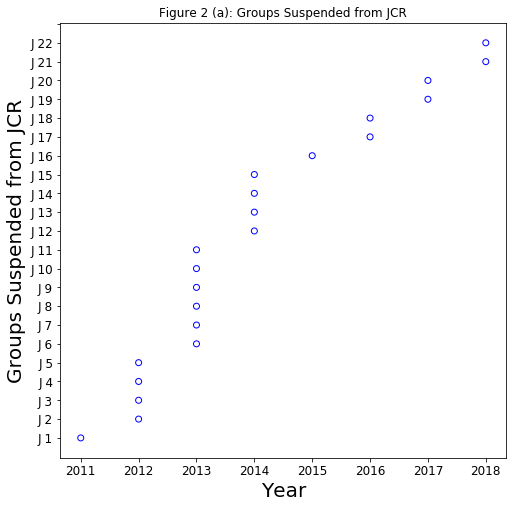

In [15]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams.update({'font.size': 10})
plt.scatter(JCR_cartels_yearly['Year'],JCR_cartels_yearly['Group_ID'],facecolors='none', edgecolors='b')
plt.yticks(range(1,24),labels = JCR_cartels_yearly['Group_ID_text'])
plt.title("Figure 2 (a): Groups Suspended from JCR")
plt.xlabel("Year")
plt.ylabel("Groups Suspended from JCR")
plt.show()

Above we have the 22 cartels formed from donor-recipient pairs suppressed from JCR reports since the citation-stacking behaviour was idenitified in 2011. We can now define this problem as a binary classification task in which journals within these 22 pairs are of the positive class, and all other journals are in the negative class. This means our positive class is incredibly rare, but also we care greatly about classifying these positive data points, and so we focus our evaluation on prcision and recall.

However, cannot simply take the overall precision and recall of all journals, claiming that CIDRe has performed well if it identifies individual journals that are suspicious. We instead wish to ask if CIDRE has detected these 22 cartels themselves, not just the individual journals. The success of CIDRE hinges on whether we can identify "bad" communities in the given network. Bad in a sense that each community represents a suspicious and cohesive group of journals citing each other in the network.

To keep our evaluation consistent with the original study, we have many of what I will define as 'classification tests'. For a given cartel in a given year $t$ (denoted $jcr_{t} \in JCR_{t}$), and for a given group detected by CIDRE in the same year (denoted $ci_{t} \in CI_{t}$) we have a classification test in which $ci_{t}$ is the set of positive predictions, and $jcr_{t}$ is the set of 'ground-truth' positive examples. Note that both $ci_{t}$ and $jcr_{t}$ are contained within $J_{t}$, the set of all journals of interest within the JIF time window $[t,t-2]$.

Thus, for a given pair ($jcr_{t}$,$ci_{t}$) in which a common journal is shared, we have a classification test where:

Precision = "overlap" = $O = \frac{|jcr_{t} \: \cap \: ci_{t}|}{|ci_{t}|}$.

Recall = $R =\frac{|jcr_{t} \: \cap \: ci_{t}|}{|jcr_{t}|} $.

NOTE: We must have one common journal betwween the pairs to test them as this implies an instance wheere CIDRE is attempting to identify the corresponding JCR cartel. All JCR and CIDRE groups are disjoint in order to align with this methodology.

Below we calculate the precision and recall for any pair that share a common journal and claim (as in the original study) that CIDRE a group $ci_{t}$ detects $jcr_{t}$ successfully if together they have $O \geq 0.5$ and share at least two journals. 

But first, we must import the MAG journal names and convert the groups detected by CIDRE into their real journal names.

In [16]:
journal_names = pd.read_csv("https://media.githubusercontent.com/media/bogeye121212/CIDRE_Dissertation/master/Validation_Code/data/ALLjournal_id-name.csv",sep = "\t").set_index('journal_id')
cidre_groups = dict()

for year in range(2000,2020):
  yearly_cart = yearly_cartels[year]
  keys = range(0,np.max(yearly_cart['group_id']+1))
  groups = dict.fromkeys(keys)
  for index, row in yearly_cart.iterrows():

    if groups[row['group_id']] == None:
      groups[row['group_id']] = [journal_names.loc[row['mag_journal_id']]['name']]
      groups[row['group_id']] = list(set(groups[row['group_id']]))

    else:
      groups[row['group_id']].append(journal_names.loc[row['mag_journal_id']]['name'])
      groups[row['group_id']] = list(set(groups[row['group_id']]))

  cidre_groups[year] = groups

for year in range(2000,2020):
  print(year,cidre_groups[year])

2000 {0: ['revue historique', 'the historical journal', 'revue d histoire des sciences', 'studies in twentieth and twenty first century literature', 'french historical studies', 'contemporary french civilization'], 1: ['journal of labor research', 'labor history', 'workingusa', 'labor studies journal', 'review of social economy', 'international labor and working class history'], 2: ['explicator', 'victorian studies', 'archives of natural history', 'the journal of imperial and commonwealth history', 'cahiers victoriens & edouardiens', 'international journal of the history of sport', 'notes and queries', 'history of education'], 3: ['journal of endovascular therapy', 'journal of endovascular surgery'], 4: ['journal of visual impairment & blindness', 'visual impairment research', 'british journal of visual impairment'], 5: ['journal of mathematical imaging and vision', 'ieice transactions on information and systems', 'computer vision and image understanding', 'journal of visual communicat

In [17]:
# Calculate precision and recall per pair sharing at least 1 journal for each pair in a given year

metrics_table = pd.DataFrame(columns = ['year','jcr_group','cidre_group','precision','recall','detected'])
plot_data_orange = dict({'year':[],'jcr_group':[]})
plot_data_goldenrod = dict({'year':[],'jcr_group':[]})
plot_data_wheat = dict({'year':[],'jcr_group':[]})

overall = 0

for year in range(2000,2020):
  
  for index, row in JCR_cartels_yearly[::-1].iterrows():
    overall_detected = False

    for cidre_group in list(cidre_groups[year].values()):
      detected = False
      ci = set(cidre_group)
      jcr = set(row['Cartel'])

      if ci & jcr:
        precision = len(ci.intersection(jcr)) / len(ci)
        recall = len(ci.intersection(jcr)) / len(jcr)

        if precision >= 0.5 and len(ci.intersection(jcr)) >= 2:
          detected = True
          overall_detected = True

          if year >=2010:
            if precision >= 0.9:
              plot_data_orange['year'].append(year)
              plot_data_orange['jcr_group'].append(row['Group_ID'])

            elif precision >= 0.7:
              plot_data_goldenrod['year'].append(year)
              plot_data_goldenrod['jcr_group'].append(row['Group_ID'])

            else:
              plot_data_wheat['year'].append(year)
              plot_data_wheat['jcr_group'].append(row['Group_ID'])

        pair_data = {'year':year,'jcr_group':list(jcr),'cidre_group':list(ci),'precision':precision,'recall':recall,'detected':detected}
        metrics_table = metrics_table.append(pair_data, ignore_index=True)

    if overall_detected == True:
      overall += 1

print(len(JCR_cartels_yearly.index))

print(metrics_table)
print("")
print("Overall, CIDRE detected: "+ str(overall) + " groups out of the 22 JCR groups at least once.")

22
    year  \
0   2007   
1   2007   
2   2007   
3   2008   
4   2008   
5   2008   
6   2008   
7   2009   
8   2009   
9   2009   
10  2009   
11  2009   
12  2009   
13  2010   
14  2010   
15  2010   
16  2011   
17  2011   
18  2011   
19  2011   
20  2011   
21  2011   
22  2011   
23  2011   
24  2012   
25  2012   
26  2012   
27  2012   
28  2012   
29  2012   
30  2012   
31  2012   
32  2012   
33  2013   
34  2013   
35  2013   
36  2013   
37  2013   
38  2013   
39  2013   
40  2013   
41  2014   
42  2014   
43  2014   
44  2014   
45  2015   
46  2016   
47  2017   

                                                                                                                                                      jcr_group  \
0   [zeitschrift fur psychosomatische medizin und psychotherapie, zeitschrift fur psychiatrie psychologie und psychotherapie]                                     
1   [progress in electromagnetics research pier, journal of electromagnetic waves 

Let's recereate Figure 2 (a) as mentioned before, but this time with the overlap included. I have been in touch with the authors who have confirmed that Figure 2 (a) in their paper should scale from 2010 to 2018 as the plot below does. Keep in mind also that the vertical reordering differences are not erroneous as the authors and I have simply labelled the JCR groups with different IDs. This below plot is truncated to the range $[2010,2018]$ so as to more easily match the Figure in the paper.

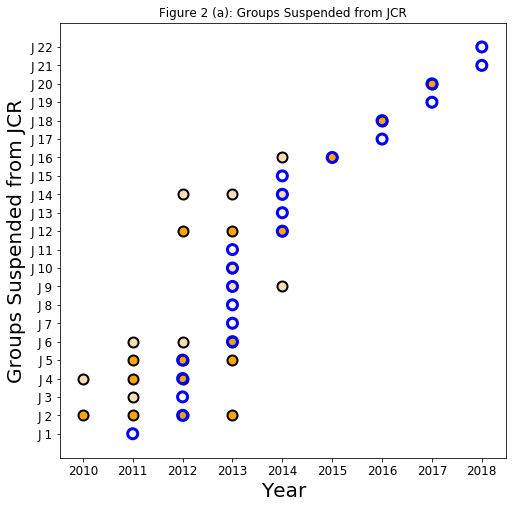

In [18]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams.update({'font.size': 10})
plt.scatter(plot_data_wheat['year'],plot_data_wheat['jcr_group'],facecolors='wheat', edgecolors='black',s = 100,linewidth=2)
plt.scatter(plot_data_goldenrod['year'],plot_data_goldenrod['jcr_group'],facecolors='goldenrod', edgecolors='black',s = 100,linewidth=2)
plt.scatter(plot_data_orange['year'],plot_data_orange['jcr_group'],facecolors='orange', edgecolors='black',s = 100,linewidth=2)
plt.scatter(JCR_cartels_yearly['Year'],JCR_cartels_yearly['Group_ID'],facecolors='none', edgecolors='blue',s = 100,linewidth=3)
plt.yticks(range(1,23),labels = JCR_cartels_yearly['Group_ID_text'])
plt.title("Figure 2 (a): Groups Suspended from JCR")
plt.xlabel("Year")
plt.ylabel("Groups Suspended from JCR")
plt.show()

The number of groups detected each year, size of groups, and overlap compared with JCR have proven to be identical. Here, we have effectively validated the works of the authors by replicating the same methodology and generating identical results. We can now move on to improving CIDRE.